In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 0 !important; width:100% !important; }</style>"))

In [194]:
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from types import SimpleNamespace
import cmath
import glob
import itertools
import tensorboard
from datetime import datetime

In [208]:
# example0:
# {
#   "EntryType":"EquivalentLoudnessMeasurement",
#   "Calibration":{
#     "HeadphoneFrequencyResponseHash":"eab807a5050b0087109ac1fd6fecbd09197a3dcd",
#     "FullScaleSineDBSPL":100
#   },
#   "Run":{
#     "ID":"1599737802659_2857050667"
#   },
#   "Evaluation":{
#     "ID":"1599738237070_2365796582",
#     "Frequency":697.9866246810275,
#     "Probe":{
#       "Type":"Noise",
#       "Params":{
#         "Level":-10,
#         "LowerLimit":966.84025,
#         "Onset":{
#           "Delay":0,
#           "Duration":0.1
#         },
#         "UpperLimit":1033.15975
#       }
#     },
#     "Combined":{
#       "Type":"Superposition",
#       "Params":[
#         {
#           "Params":{
#             "Level":-40,
#             "LowerLimit":966.84025,
#             "Onset":{
#               "Delay":0.5,
#               "Duration":0.1
#             },
#             "UpperLimit":1033.15975
#           },
#           "Type":"Noise"
#         },{
#           "Params":{
#             "Level":-20,
#             "LowerLimit":672.9766301106662,
#             "Onset":{
#               "Delay":0,
#               "Duration":0.1
#             },
#             "UpperLimit":722.9966192513888
#           },
#           "Type":"Noise"
#         }
#       ]
#     }
#   },
#   "Results":{
#     "ProbeGainForEquivalentLoudness":0.003107877399956887,
#     "ProbeDBSPLForEquivalentLoudness":39.84927756697657
#   }
# }
def experiment_result_to_example(exp, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000, noise_floor_db_spl=30):
    if exp.EntryType != 'EquivalentLoudnessMeasurement':
        return None
    assert exp.Evaluation.Probe.Type == 'Noise'
    assert exp.Evaluation.Combined.Type == 'Superposition'
    for part in exp.Evaluation.Combined.Params:
        assert part.Type == 'Noise'
        # If this part isn't the probe.
        if (part.Params.LowerLimit != exp.Evaluation.Probe.Params.LowerLimit or
            part.Params.UpperLimit != exp.Evaluation.Probe.Params.UpperLimit):
            # We want to ignore evaluations where probe and masker overlap.
            if ((part.Params.LowerLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.LowerLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.UpperLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.LowerLimit <= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit >= exp.Evaluation.Probe.Params.UpperLimit)):
                return None
    assert exp.Results.ProbeGainForEquivalentLoudness > 0
    assert exp.Results.ProbeDBSPLForEquivalentLoudness != None
    assert exp.Calibration.FullScaleSineDBSPL > 0

    bin_width = sample_rate / window_size
    def add_noise(coeffs, lower_limit, upper_limit, total_power_db_fs):
        first_bin = int(np.floor(lower_limit/bin_width))
        last_bin = int(np.ceil(upper_limit/bin_width))
        noise_coeffs = (complex(0, 1) * np.random.normal(size=[last_bin-first_bin]) + 
                        np.random.normal(size=[last_bin-first_bin]))
        noise_power_db_fs = 10 * np.log10(np.sum(noise_coeffs ** 2))
        scale = 10 ** ((total_power_db_fs - noise_power_db_fs) / 20)
        noise_coeffs *= scale
        for bin_idx in range(first_bin, first_bin + 1):
            coeffs[bin_idx] += noise_coeffs[bin_idx - first_bin]
            coeffs[-bin_idx] += np.conjugate(coeffs[bin_idx])
    coeffs = np.zeros([window_size], dtype=np.complex128)
    add_noise(coeffs, 20, 14000, noise_floor_db_spl - car_fs_sine_db_spl)
    for part in exp.Evaluation.Combined.Params:
        part_db_spl = exp.Calibration.FullScaleSineDBSPL + part.Params.Level
        part_db_fs = part_db_spl - car_fs_sine_db_spl
        add_noise(coeffs, part.Params.LowerLimit, part.Params.UpperLimit, part_db_fs)
    
    relevant_bins = np.zeros([int(window_size/2)], dtype=np.complex128)
    first_relevant_bin = int(np.floor(exp.Evaluation.Probe.Params.LowerLimit/bin_width))
    last_relevant_bin = int(np.ceil(exp.Evaluation.Probe.Params.UpperLimit/bin_width))
    for bin_idx in range(first_relevant_bin, last_relevant_bin + 1):
        relevant_bins[bin_idx] = 1

    true_loudness = np.array([exp.Results.ProbeDBSPLForEquivalentLoudness], dtype=np.complex128)
    
    res = tf.concat([np.fft.ifft(coeffs), true_loudness, relevant_bins], axis=0)
    return res

def load_examples(glb, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000):
    lines_iter = itertools.chain(*map(lambda f: open(f).readlines(), glob.glob(glb)))
    json_iter = map(lambda l: json.loads(l, object_hook=lambda o: SimpleNamespace(**o)), lines_iter)
    only_eval_iter = filter(lambda exp: exp.EntryType == 'EquivalentLoudnessMeasurement', json_iter)
    sorted_iter = sorted(only_eval_iter, key=lambda exp: exp.Evaluation.ID)
    examples_iter = map(lambda l: experiment_result_to_example(l, car_fs_sine_db_spl=car_fs_sine_db_spl, window_size=window_size, sample_rate=sample_rate), sorted_iter)
    filtered_iter = filter(lambda e: e != None, examples_iter)
    ds = tf.data.Dataset.from_tensor_slices(list(filtered_iter))
    input_true_ds = ds.map(lambda ex: (ex[:window_size], ex[window_size:]))
    return input_true_ds
            
def plot_pz(f):
    _, ax = plt.subplots(figsize=(8,8))
    ax.add_patch(patches.Circle((0,0),
                              radius=1,
                              fill=False,
                              color='black',
                              ls='solid',
                              alpha=0.1))
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))

    ax.plot(tf.reshape(tf.math.real(f.poles), [-1,1]), tf.reshape(tf.math.imag(f.poles), [-1,1]),
            'x', markersize=9, alpha=0.5)
    ax.plot(tf.reshape(tf.math.real(f.zeros), [-1,1]), tf.reshape(tf.math.imag(f.zeros), [-1,1]),
            'o', color='none', markeredgecolor='red',
            markersize=9, alpha=0.5)
    plt.show()

def plot_many_z(many_z, sample_rate=48000, figsize=(12,4)):
    xaxis = np.tile(np.linspace(0,
                                (many_z.shape[1] - 1) * sample_rate *
                                0.5 / many_z.shape[1],
                                many_z.shape[1]), [many_z.shape[0], 1])
    _, ax = plt.subplots(figsize=figsize)    
    ax.set_xscale('log')
    ax.set_xlim((10,20000))
    ax.set_ylim((-20, 70))
    x = np.transpose(xaxis[:,:xaxis.shape[1]//2])
    y = np.transpose(20 * np.log10(np.abs(many_z[:,:many_z.shape[1]//2])))
    ax.plot(x, y)
    plt.show()
        
def plot_snr(snr, channels=[None, None], bins=[None, None]):
    max_snr = np.nanmax(snr)
    min_snr = np.nanmin(snr)
    scaled_snr = ((snr - min_snr) / (max_snr - min_snr))[:,:,None]
    if channels[1] != None:
        scaled_snr = scaled_snr[:channels[1]]
    if channels[0] != None:
        scaled_snr = scaled_snr[channels[0]]
    if bins[1] != None:
        scaled_snr= scaled_snr[:,:bins[1]]
    if bins[0] != None:
        scaled_snr = scaled_snr[:,bins[0]:]
    scaled_snr = np.repeat(scaled_snr, 4, axis=0)
    pixels = np.concatenate([scaled_snr, scaled_snr/2, scaled_snr/2], axis=2)
    plt.figure(figsize = (20,10))
    plt.imshow(pixels, interpolation='bicubic')
    plt.show()
    
def plot_pred(model, ds):
    truth = []
    pred = []
    worst_example = None
    worst_error = None
    worst_index = None
    example_index = 0
    for ex in ds:
        x, y_true = ex
        for val in y_true[:,0]:
            truth.append(np.abs(val))
        y_pred = model(x)
        pred_min = np.min(y_pred, axis=1)[:,None]
        irrelevant_reduced = np.where(np.abs(y_true[:,1:]) != 0, y_pred, pred_min-1)
        for idx, val in enumerate(np.max(irrelevant_reduced, axis=1)):
            pred.append(val)
            err = (truth[idx] - val) ** 2 * truth[idx]            
            if worst_error == None or err > worst_error:
                worst_error = err
                worst_example = x[idx]
                worst_index = example_index
            example_index += 1
    plt.figure(figsize=(20,10))
    steps = np.arange(len(truth))
    plt.plot(steps, truth)
    plt.plot(steps, pred)
    plt.show()
    return (worst_index, worst_error, worst_example)

def take_num_of_len(length, num):
    def helper(pos, remaining):
        combos = []
        for i in range(pos, length):
            if remaining == 1:
                combos.append([i])
            else:
                for remainder in helper(i+1, remaining-1):
                    combo = [i]
                    for el in remainder:
                        combo.append(el)
                    combos.append(combo)
        return combos
    return helper(0, num)

def coeffs(constants):
    res = []
    for num in range(len(constants)+1):
        s = 0
        if num == 0:
            s = 1
        for parts in take_num_of_len(len(constants), num):
            prod = 1
            for part in parts:
                prod *= -constants[part]
            s += prod
        res.append(s)
    return res

class PZCell:
    def __init__(self, gain, poles, zeros):
        self.gain = gain
        self.poles = poles
        self.zeros = zeros
        self.state_size = [[2, len(poles)+1]]
        self.output_size = 1
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return tf.zeros(shape=[batch_size, self.state_size[0][0], self.state_size[0][1]], dtype=tf.complex128)
    def call(self, input_at_t, states_at_t):
        input_at_t = tf.cast(input_at_t, dtype=tf.complex128)
        pole_coeffs = coeffs(self.poles)
        zero_coeffs = coeffs(self.zeros)
        zero_offset = max(0, len(pole_coeffs) - len(zero_coeffs))
        output_at_t = tf.constant(0, shape=input_at_t.shape, dtype=tf.complex128)
        output_at_t += tf.cast(input_at_t, dtype=tf.complex128) * self.gain * zero_coeffs[0]
        for idx in range(1, len(zero_coeffs)):
            output_at_t += states_at_t[:,0,idx+zero_offset] * self.gain * zero_coeffs[idx]
        for idx in range(1, len(pole_coeffs)):
            output_at_t -= states_at_t[:,1,idx] * pole_coeffs[idx]
        output_at_t = tf.math.divide_no_nan(output_at_t, pole_coeffs[0])
        new_state_contrib = tf.concat([input_at_t[:,None,None], output_at_t[:,None,None]], axis=1)
        states_at_t_plus_1 = tf.concat([new_state_contrib, states_at_t], axis=2)[:,:,:states_at_t.shape[2]]
        return (output_at_t, states_at_t_plus_1)
        
class RNNWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, rnn_cell, **kwargs):
        super().__init__(self, **kwargs)
        self.rnn_cell = rnn_cell
    def build(self, input_shape):
        self.rnn_state = self.rnn_cell.get_initial_state(inputs=None, batch_size=input_shape[0], dtype=tf.float64)
    def call(self, inputs, **kwargs):
        output_ta = tf.TensorArray(size=inputs.shape[1], dtype=tf.complex128)
        for step in range(inputs.shape[1]):
            output_at_step, self.rnn_state = self.rnn_cell.call(inputs[:, step], self.rnn_state)
            output_ta = output_ta.write(step, output_at_step)            
        res = tf.math.real(output_ta.stack())
        output_ta.mark_used()

def pz_filter(gain, poles, zeros, inputs):
    all_zeros = tf.concat([zeros, tf.math.conj(zeros)], axis=0)
    all_poles = tf.concat([poles, tf.math.conj(poles)], axis=0)
    z = tf.exp(tf.complex(tf.cast(0.0, tf.math.real(gain).dtype),
                          tf.linspace(
                              tf.cast(0.0, tf.math.imag(gain).dtype), 
                              # (inputs.shape[1] - 1) / inputs.shape[1] to not include 2*pi 
                              (inputs.shape[1] - 1)*2*math.pi/inputs.shape[1],
                              inputs.shape[1])), name='z')
    return (gain *
            tf.cast(inputs, gain.dtype) *
            tf.math.reduce_prod(z[None,:,None] - all_zeros[None,None,:], axis=2) /
            tf.math.reduce_prod(z[None,:,None] - all_poles[None,None,:], axis=2))

class CARLayer(tf.keras.layers.Layer):
    # See 'Human and Machine Hearing', 16.2-16.3,
    # and https://github.com/google/carfac/.
    def __init__(self, sample_rate=48000, erb_per_step=0.5, **kwargs):
        super().__init__(**kwargs)
        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate
        
        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 / default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        self._high_f_damping_compression = self.add_weight(
            name='high_f_damping_compression',
            initializer=tf.keras.initializers.Constant(0.5),
            trainable=self.trainable)
        # Controls distance from pole to zero.
        self._zero_ratio = self.add_weight(
            name='zero_ratio',
            initializer=tf.keras.initializers.Constant(2 ** 0.5),
            trainable=self.trainable)
        # min/max zeta controls max damping.
        self._min_zeta = self.add_weight(
            name='min_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.1, self._erb_per_step)),
            trainable=self.trainable)
        self._max_zeta = self.add_weight(
            name='max_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.35, self._erb_per_step)),
            trainable=self.trainable)
        # Controls how we convert from Hz to Cams.
        # Defaults at numbers from B.C.J. Moore and B.R. Glasberg, "Suggested formulae for calculating auditory-filter bandwidths and excitation patterns".
        self._erb_constant_0 = self.add_weight(
            name='erb_constant_0(24.7)',
            initializer=tf.keras.initializers.Constant(24.7),
            trainable=self.trainable)
        self._erb_constant_1 = self.add_weight(
            name='erb_constant_1(1.0)',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable)
        self._erb_constant_2 = self.add_weight(
            name='erb_constant_2(4.37)',
            initializer=tf.keras.initializers.Constant(4.37),
            trainable=self.trainable)

    def get_config(self):
        config = super().get_config()
        config['erb_per_step'] = self._erb_per_step
        config['sample_rate'] = self._sample_rate
        return config
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        max_freq = 20000
        min_freq = 20

        # Equivalent rectangular bandwidth, the width of the theoretical rectangular cochlear place filter.
        def ERB(f):
            return self._erb_constant_0 * (self._erb_constant_1 + self._erb_constant_2 * f * 0.001)

        pole_freqs_ta = tf.TensorArray(size=0, dynamic_size=True, dtype=self.dtype, clear_after_read=False)
        pole_freqs_ta = pole_freqs_ta.write(0, max_freq)
        while pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)) > min_freq:
            pole_freqs_ta = pole_freqs_ta.write(pole_freqs_ta.size(), pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)))
        pole_freqs = pole_freqs_ta.stack()
        n_poles = pole_freqs_ta.size()

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = tf.math.square(self._zero_ratio) - 1
        pole_thetas = pole_freqs * 2 * np.pi / self._sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = tf.math.cos(pole_thetas)
        c0 = tf.math.sin(pole_thetas)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - self._high_f_damping_compression * tf.math.pow(x, 3))

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * self._max_zeta)
        min_zetas = self._min_zeta + (0.25 * ((ERB(pole_freqs) / pole_freqs) - self._min_zeta))
        zr_coeffs *= (self._max_zeta - min_zetas)
        r = r1 + zr_coeffs
        h = c0 * f
        g0 = tf.cast((1 - 2 * r * a0 + tf.math.square(r)) / (1 - 2 * r * a0 + h * r * c0 + tf.math.square(r)), tf.complex128)
        self.poles = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(pole_thetas, tf.float64)))
        zero_thetas = tf.math.acos(a0 - h * c0 / 2)
        self.zeros = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(zero_thetas, tf.float64)))

        # Here is where I diverge a lot, by just creating frequency domain filters
        # instead of difference equations.
        res = tf.TensorArray(size=0, dynamic_size=True, dtype=tf.complex128, clear_after_read=False)
        tmp = tf.cast(inputs, tf.complex128)
        for idx in range(n_poles):
            tmp = pz_filter(g0[idx], self.poles[idx:idx+1], self.zeros[idx:idx+1], tmp)
            res = res.write(res.size(), tmp)
        res = res.stack()
        return tf.transpose(res, [1,0,2])

class OuterEarLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Numbers from https://colab.corp.google.com/drive/161a2riUCQeYYEPhlRc7XqtI9OWUMwQQX?usp=sharing.
        self.poles = self.add_weight(
            name='poles',
            dtype=tf.complex128,
            shape=[4],
            initializer=tf.keras.initializers.Constant([(-0.05429768147702485+1.4172655611120915e-05j),
                                                        (0.2917622403739163+0.7731812636894612j),
                                                        (0.8768382244780407-0.31120458350060115j),
                                                        (0.6598943546882394-0.46728573398560225j)]),
            trainable=self.trainable)
        self.zeros = self.add_weight(
            name='zeros',
            dtype=tf.complex128,
            shape=[3],
            initializer=tf.keras.initializers.Constant([(0.635496172349615+0.14499945287904842j),
                                                        (0.30987058966944614-0.8574194617385421j),
                                                        (0.5721096307971768-2.2915816453724273e-05j)]),
            trainable=self.trainable)
        self.gain = self.add_weight(
                name='gain',
                dtype=tf.complex128,
                initializer=tf.keras.initializers.Constant(1.34),
                trainable=self.trainable)
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        return pz_filter(self.gain, self.poles, self.zeros, inputs)

class SNRLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    # [...,fft_coeffs] => [...,channels,db_snr]
    def call(self, inputs, **kwargs):
        gain = tf.math.abs(inputs)
        signal_power = tf.math.square(gain)
        noise_power = tf.math.reduce_sum(signal_power, axis=2)[:,:,None] - signal_power
        snr = tf.math.divide_no_nan(tf.math.square(signal_power), noise_power)
        res = tf.cast(10.0, self.dtype) * tf.cast(tf.math.log(snr + 1e-16), self.dtype) / tf.cast(tf.math.log(10.0), self.dtype)
        res = res[:,:,:res.shape[2]//2]
        return res

class LoudnessPredictorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        true_partial_loudness = y_true[:,0]
        relevant_bins = tf.cast(y_true[:,1:], tf.bool)
        min_psnr = tf.math.reduce_min(y_pred, axis=1)[:,None]
        reduced_irrelevant_bins = tf.where(relevant_bins, y_pred, min_psnr - 1)
        psnr_across_relevant_bins = tf.math.reduce_max(reduced_irrelevant_bins, axis=1)
        res = tf.cast(tf.keras.losses.MSE(true_partial_loudness, psnr_across_relevant_bins), true_partial_loudness.dtype) * true_partial_loudness
        return res

class LoudnessPredictorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._loudness_offset = self.add_weight(
            name='loudness_offset',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
        self._loudness_scale = self.add_weight(
            name='loudness_scale',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
    # [...,fft_bin] => [...,equivalent_db_spl]
    def call(self, inputs, **kwargs):
        psnr_per_bin = tf.math.reduce_max(inputs, axis=1)
        res = self._loudness_offset * 40 + self._loudness_scale * psnr_per_bin
        return res


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3447, in run_code
    return outflag  File "<ipython-input-192-963e432ce87c>", line 10, in <module>
    ear_layer(ex0[0])  File "/home/zond/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1039, in __call__
    return outputs  File "<ipython-input-191-ba194bc0456e>", line 276, in call
    output_at_step, self.rnn_state = self.rnn_cell.call(inputs[:, step], self.rnn_state)  File "/home/zond/.local/lib/python3.9/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.

In [209]:
ear_cell = PZCell(tf.cast(1.34, dtype=tf.complex128),
                 tf.constant([(-0.05429768147702485+1.4172655611120915e-05j),
                  (0.2917622403739163+0.7731812636894612j),
                  (0.8768382244780407-0.31120458350060115j),
                  (0.6598943546882394-0.46728573398560225j)], dtype=tf.complex128),
                 tf.constant([(0.635496172349615+0.14499945287904842j),
                  (0.30987058966944614-0.8574194617385421j),
                  (0.5721096307971768-2.2915816453724273e-05j)], dtype=tf.complex128))
ear_layer = RNNWrapperLayer(ear_cell)
ear_layer(ex0[0])

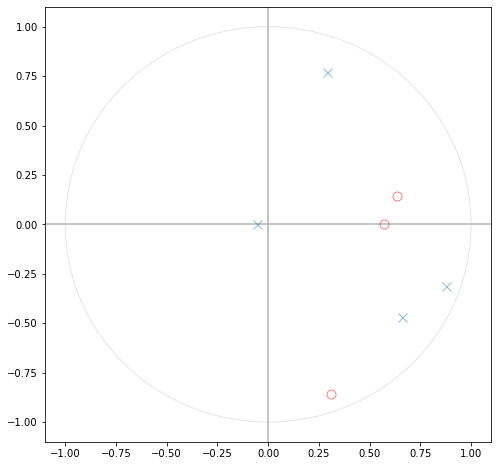

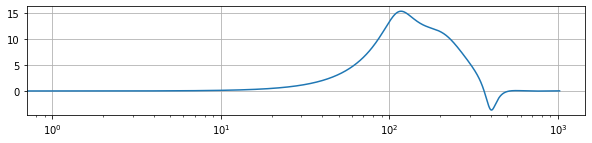

In [55]:
window_size = 2048
plot_pz(OuterEarLayer())
z = np.ones([1, 2048], dtype=np.complex128)
fy = tf.math.abs(OuterEarLayer()(z)[0])
y = 20 * np.log10(fy[:len(fy)//2])
plt.figure(figsize=(10,2))
plt.xscale('log')
plt.plot(np.arange(0, len(y)), y)
plt.grid(True)
plt.show()

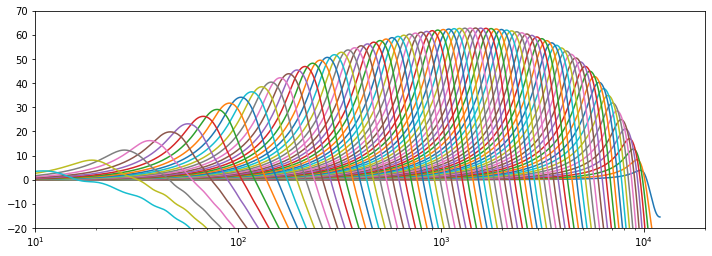

In [94]:
plot_many_z(CARLayer()(np.ones([1, 48000], dtype=np.complex128))[0])

(<tf.Tensor: shape=(1, 2048), dtype=complex128, numpy=
array([[0.00010499+0.j, 0.00010549+0.j, 0.00010605+0.j, ...,
        0.00010391+0.j, 0.0001042 +0.j, 0.00010456+0.j]])>, <tf.Tensor: shape=(1, 1025), dtype=complex128, numpy=
array([[59.10062105+0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j]])>)


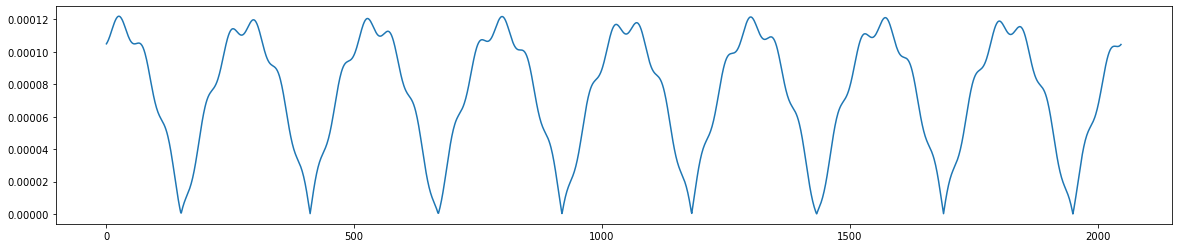

In [130]:
one_khz_examples = load_examples('/home/zond/DriveFileStream/My Drive/korvapuusti/listening_tests/modern_format/by_probe_center/1kHz/*/*.json').batch(1)
for ex in one_khz_examples.take(1):
    ex0 = ex
print(ex)
plt.figure(figsize=(20,4))
plt.plot(np.arange(window_size), np.abs(ex0[0][0,:window_size]))
plt.show()

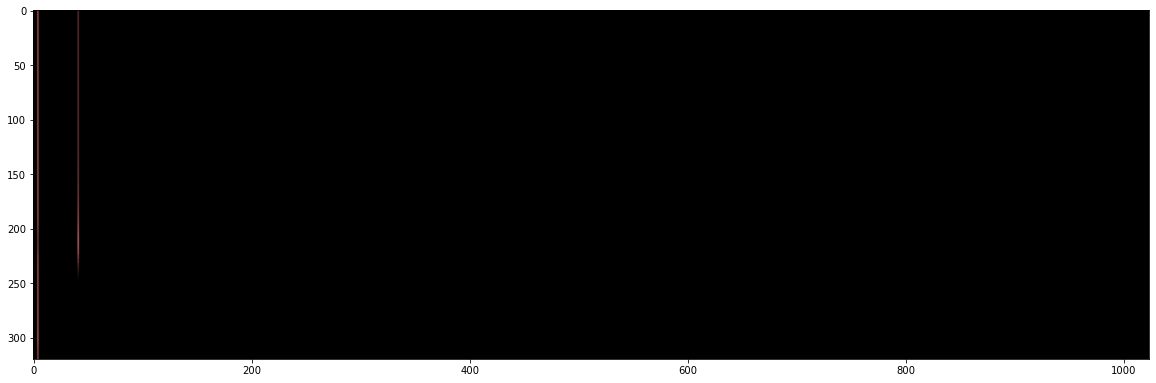

In [96]:
plot_snr(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))[0])

In [97]:
print(LoudnessPredictorLayer()(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))))

tf.Tensor(
[[ -87.369774 -120.       -120.       ... -120.       -120.
  -120.      ]
 [ -85.78482  -120.       -120.       ... -120.       -120.
  -120.      ]
 [ -79.49568  -120.       -120.       ... -120.       -120.
  -120.      ]
 ...
 [ -60.349495 -120.       -120.       ... -120.       -120.
  -120.      ]
 [ -94.531204 -120.       -120.       ... -120.       -120.
  -120.      ]
 [ -68.298195 -120.       -120.       ... -120.       -120.
  -120.      ]], shape=(128, 1024), dtype=float32)


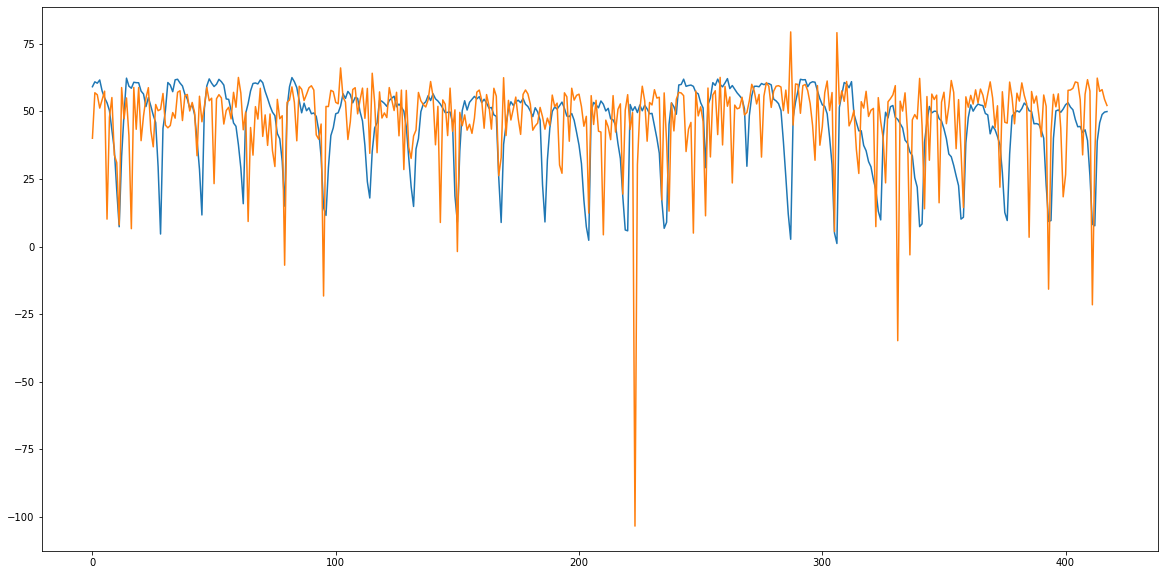

worst error at 331 335533.51466930483


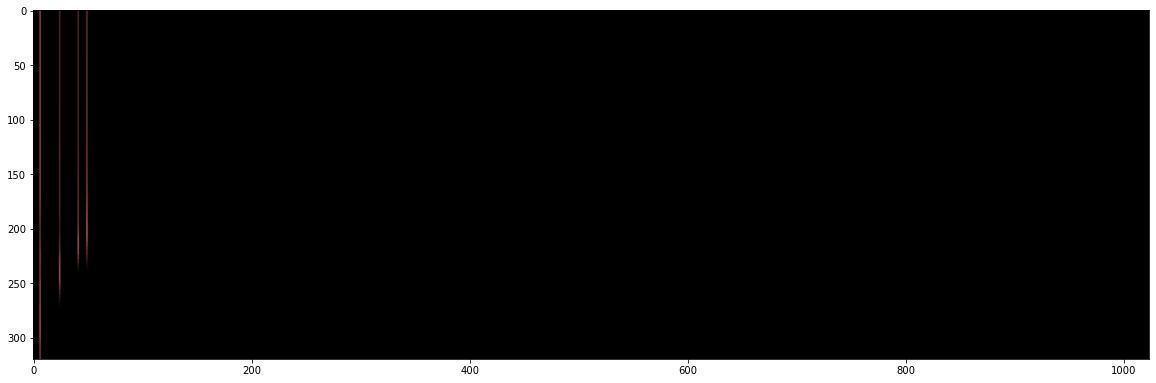

In [102]:
lpm = tf.keras.Sequential()
ear = OuterEarLayer(input_shape=[window_size])
lpm.add(ear)
car = CARLayer()
lpm.add(car)
snr = SNRLayer()
lpm.add(snr)
lpm.add(LoudnessPredictorLayer())
lpm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=LoudnessPredictorLoss())
(worst_index, worst_error, worst_example) = plot_pred(lpm, one_khz_examples)
print('worst error at', worst_index, worst_error)
plot_snr(snr(car(ear(worst_example[None,:])))[0])

Epoch 1/10
4/4 - 6s - loss: 16804.1992
Epoch 2/10
4/4 - 4s - loss: 16776.6992
Epoch 3/10
4/4 - 4s - loss: 16753.1875
Epoch 4/10
4/4 - 5s - loss: 16732.0898
Epoch 5/10
4/4 - 5s - loss: 16713.2168
Epoch 6/10
4/4 - 5s - loss: 16695.9297
Epoch 7/10
4/4 - 6s - loss: 16679.8496
Epoch 8/10
4/4 - 5s - loss: 16665.0547
Epoch 9/10
4/4 - 6s - loss: 16651.4434
Epoch 10/10
4/4 - 4s - loss: 16638.7969


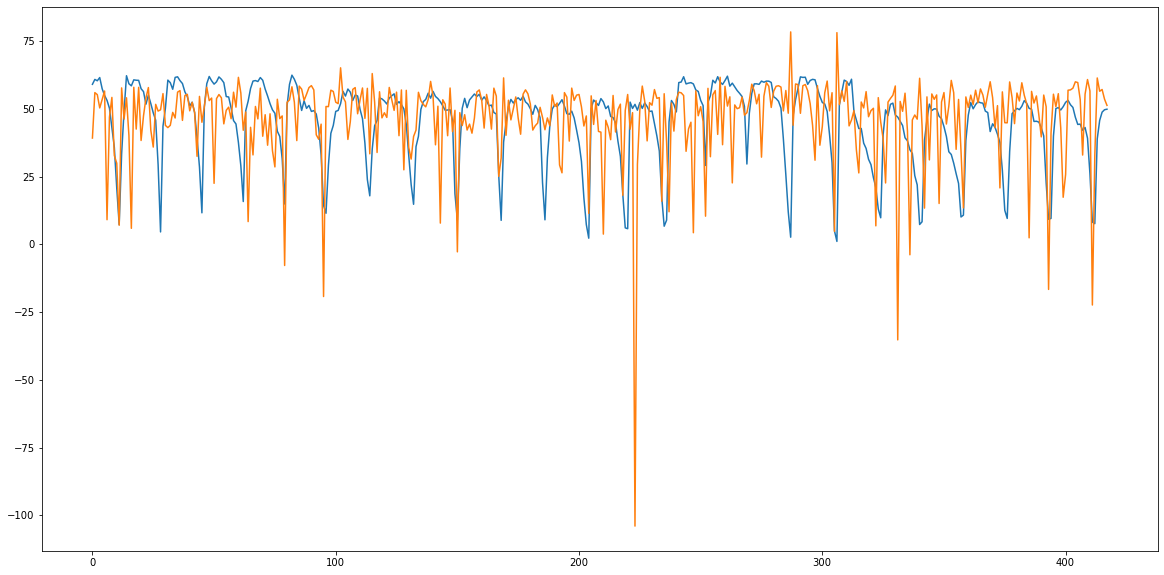

Epoch 1/10
4/4 - 4s - loss: 16627.0547
Epoch 2/10
4/4 - 7s - loss: 16616.0703
Epoch 3/10
4/4 - 4s - loss: 16605.6582
Epoch 4/10
4/4 - 5s - loss: 16595.7734
Epoch 5/10
4/4 - 5s - loss: 16586.2852
Epoch 6/10
4/4 - 4s - loss: 16577.1797
Epoch 7/10
4/4 - 4s - loss: 16568.3066
Epoch 8/10
4/4 - 4s - loss: 16559.6250
Epoch 9/10
4/4 - 4s - loss: 16551.1152
Epoch 10/10
4/4 - 4s - loss: 16542.6875


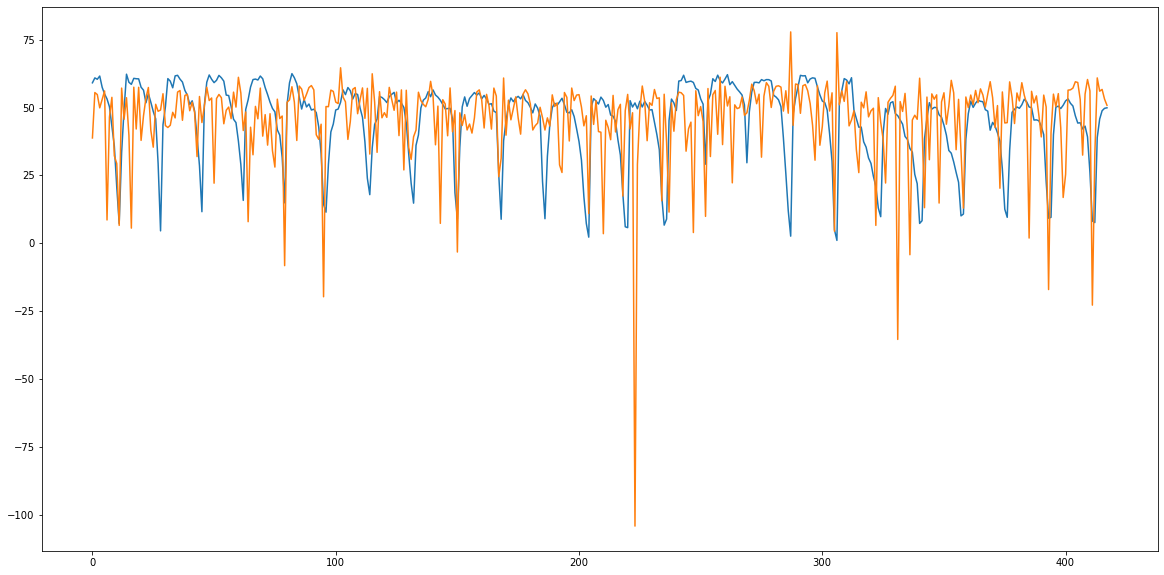

Epoch 1/10
4/4 - 4s - loss: 16534.3906
Epoch 2/10
4/4 - 5s - loss: 16526.1211
Epoch 3/10
4/4 - 4s - loss: 16517.9648
Epoch 4/10
4/4 - 4s - loss: 16510.1797
Epoch 5/10
4/4 - 5s - loss: 16502.4707
Epoch 6/10
4/4 - 4s - loss: 16494.7480
Epoch 7/10
4/4 - 5s - loss: 16487.1055
Epoch 8/10
4/4 - 5s - loss: 16479.4277
Epoch 9/10
4/4 - 5s - loss: 16471.7734
Epoch 10/10
4/4 - 5s - loss: 16464.0820


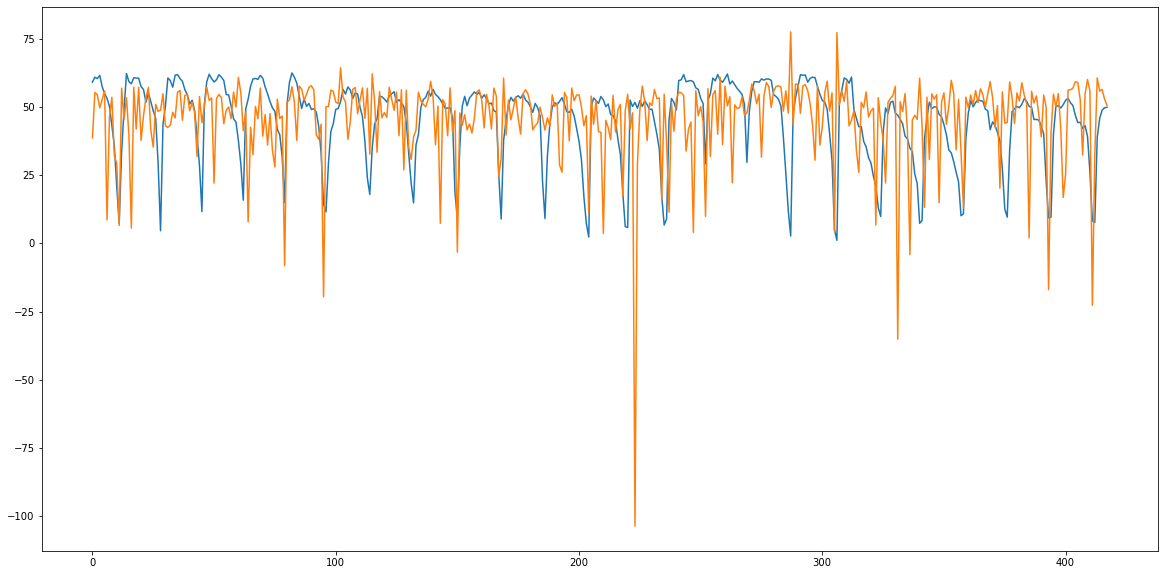

Epoch 1/10
4/4 - 4s - loss: 16456.3965
Epoch 2/10
4/4 - 5s - loss: 16448.7207
Epoch 3/10
4/4 - 5s - loss: 16440.9805
Epoch 4/10
4/4 - 4s - loss: 16433.2734
Epoch 5/10
4/4 - 5s - loss: 16425.5449
Epoch 6/10
4/4 - 5s - loss: 16417.7988
Epoch 7/10
4/4 - 5s - loss: 16410.0254
Epoch 8/10
4/4 - 5s - loss: 16402.2910
Epoch 9/10
4/4 - 5s - loss: 16394.5195
Epoch 10/10
4/4 - 4s - loss: 16386.7402


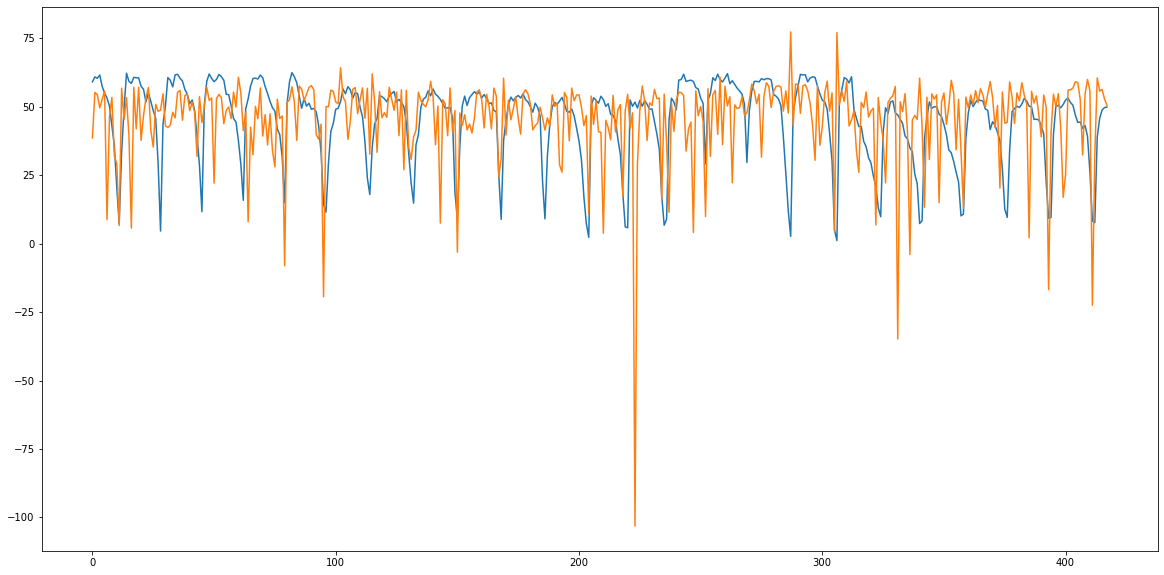

Epoch 1/10
4/4 - 5s - loss: 16378.9639
Epoch 2/10
4/4 - 5s - loss: 16371.1914
Epoch 3/10
4/4 - 5s - loss: 16363.4092
Epoch 4/10
4/4 - 4s - loss: 16355.6338
Epoch 5/10
4/4 - 5s - loss: 16347.8408
Epoch 6/10
4/4 - 5s - loss: 16340.0332
Epoch 7/10
4/4 - 5s - loss: 16332.2715
Epoch 8/10
4/4 - 5s - loss: 16324.4785
Epoch 9/10
4/4 - 5s - loss: 16316.6758
Epoch 10/10
4/4 - 5s - loss: 16308.9004


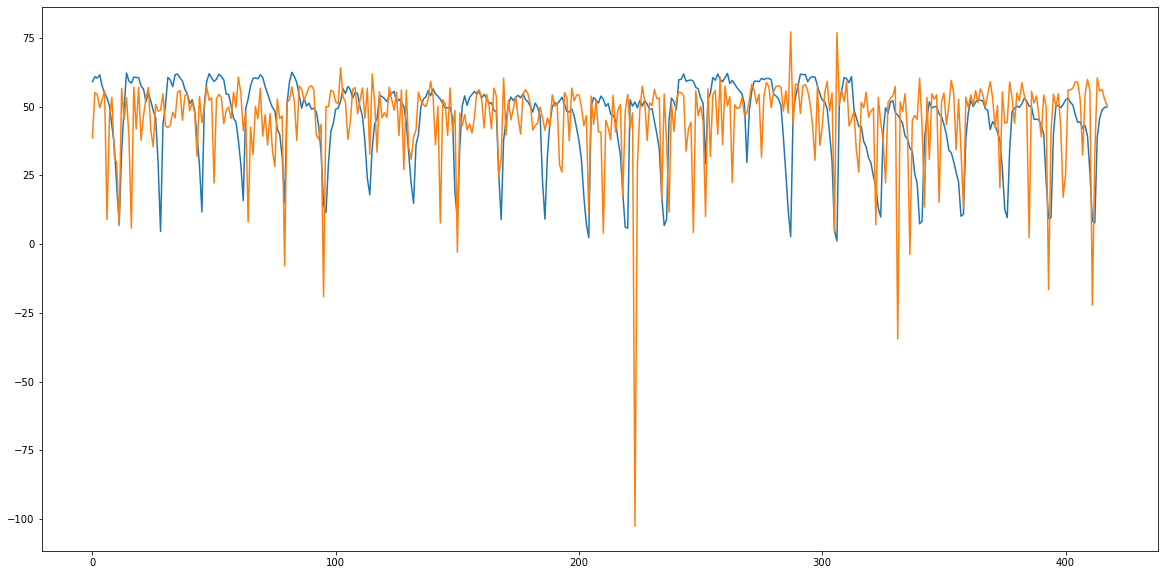

Epoch 1/10
4/4 - 5s - loss: 16301.0967
Epoch 2/10
4/4 - 5s - loss: 16293.3564
Epoch 3/10
4/4 - 4s - loss: 16285.5703
Epoch 4/10
4/4 - 5s - loss: 16277.7764
Epoch 5/10
4/4 - 5s - loss: 16269.9990
Epoch 6/10
4/4 - 4s - loss: 16262.2559
Epoch 7/10
4/4 - 4s - loss: 16254.5107
Epoch 8/10
4/4 - 4s - loss: 16246.7295
Epoch 9/10
4/4 - 5s - loss: 16238.9746
Epoch 10/10
4/4 - 5s - loss: 16231.2441


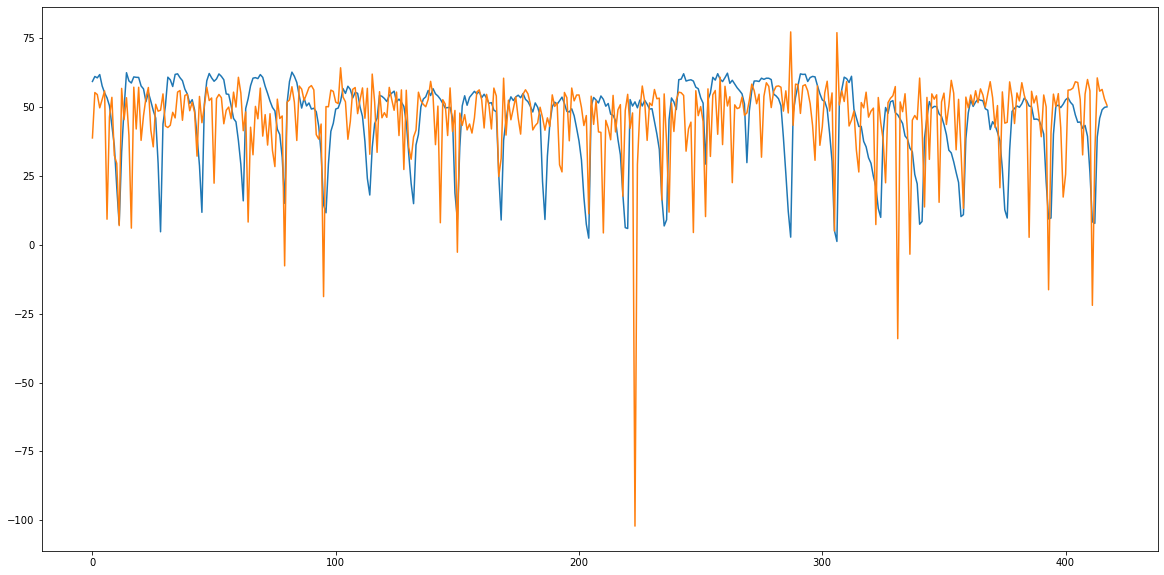

Epoch 1/10
4/4 - 6s - loss: 16223.4902
Epoch 2/10
4/4 - 5s - loss: 16215.7344
Epoch 3/10
4/4 - 5s - loss: 16208.0098
Epoch 4/10
4/4 - 5s - loss: 16200.2871
Epoch 5/10
4/4 - 5s - loss: 16192.5654
Epoch 6/10
4/4 - 5s - loss: 16184.8496
Epoch 7/10
4/4 - 5s - loss: 16177.1602
Epoch 8/10
4/4 - 5s - loss: 16169.4502
Epoch 9/10
4/4 - 4s - loss: 16161.7510
Epoch 10/10
4/4 - 4s - loss: 16154.0518


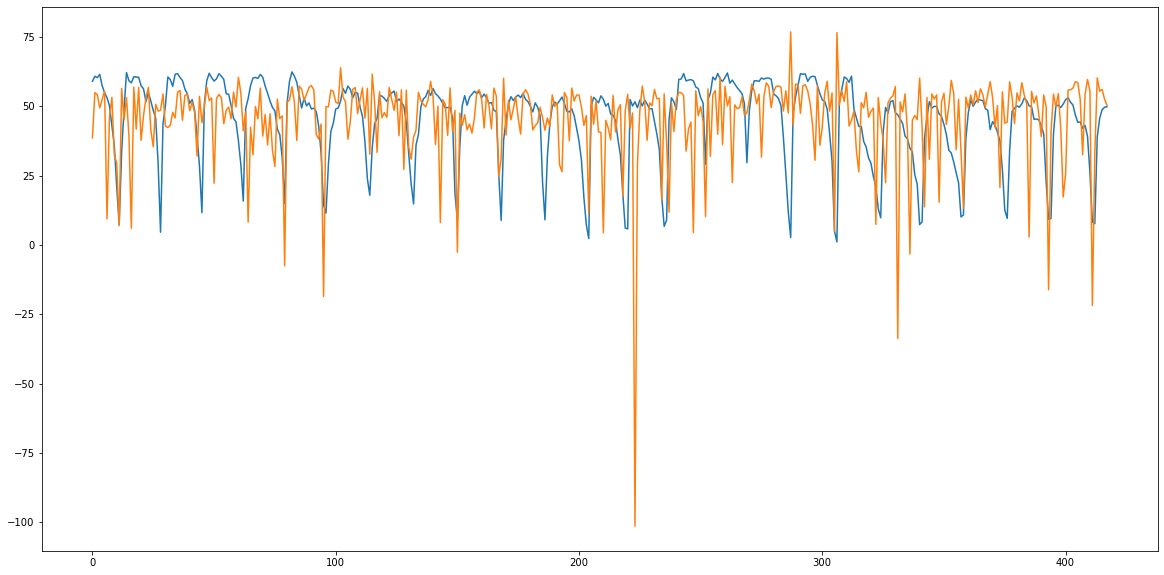

Epoch 1/10
4/4 - 4s - loss: 16146.4023
Epoch 2/10
4/4 - 4s - loss: 16138.6875
Epoch 3/10
4/4 - 4s - loss: 16131.0215
Epoch 4/10
4/4 - 4s - loss: 16123.3760
Epoch 5/10
4/4 - 4s - loss: 16115.6953
Epoch 6/10
4/4 - 4s - loss: 16108.0703
Epoch 7/10
4/4 - 4s - loss: 16100.3975
Epoch 8/10
4/4 - 4s - loss: 16092.7734
Epoch 9/10
4/4 - 4s - loss: 16085.1641
Epoch 10/10
4/4 - 4s - loss: 16077.5352


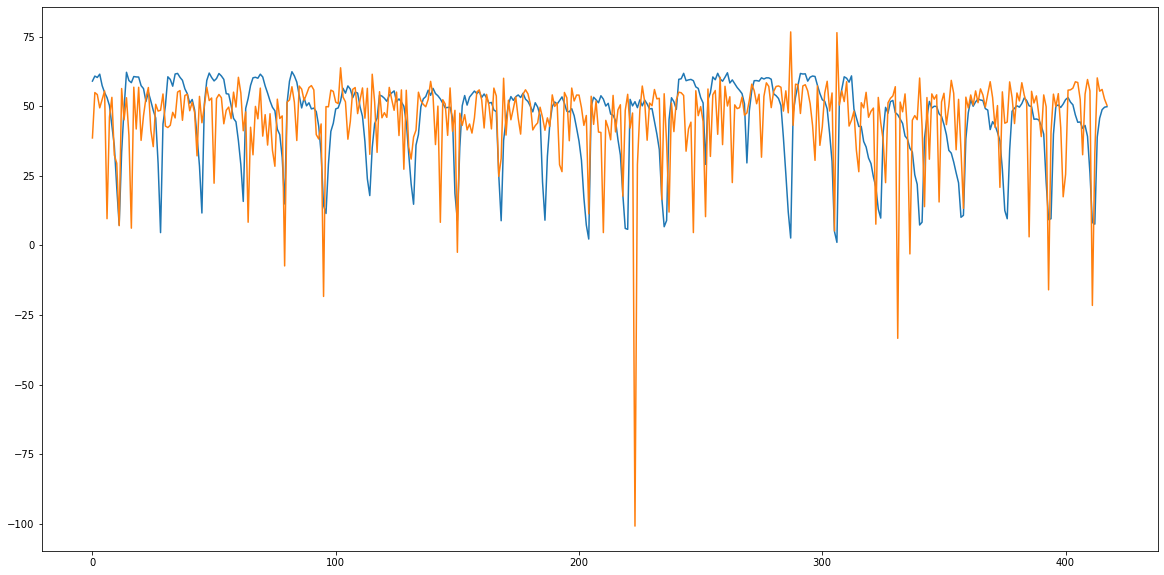

Epoch 1/10
4/4 - 5s - loss: 16069.9219
Epoch 2/10
4/4 - 4s - loss: 16062.2852
Epoch 3/10
4/4 - 4s - loss: 16054.6660
Epoch 4/10
4/4 - 5s - loss: 16047.0713
Epoch 5/10
4/4 - 4s - loss: 16039.4795
Epoch 6/10
4/4 - 4s - loss: 16031.8809
Epoch 7/10
4/4 - 4s - loss: 16024.2822
Epoch 8/10
4/4 - 4s - loss: 16016.7080
Epoch 9/10
4/4 - 4s - loss: 16009.1416
Epoch 10/10
4/4 - 4s - loss: 16001.5830


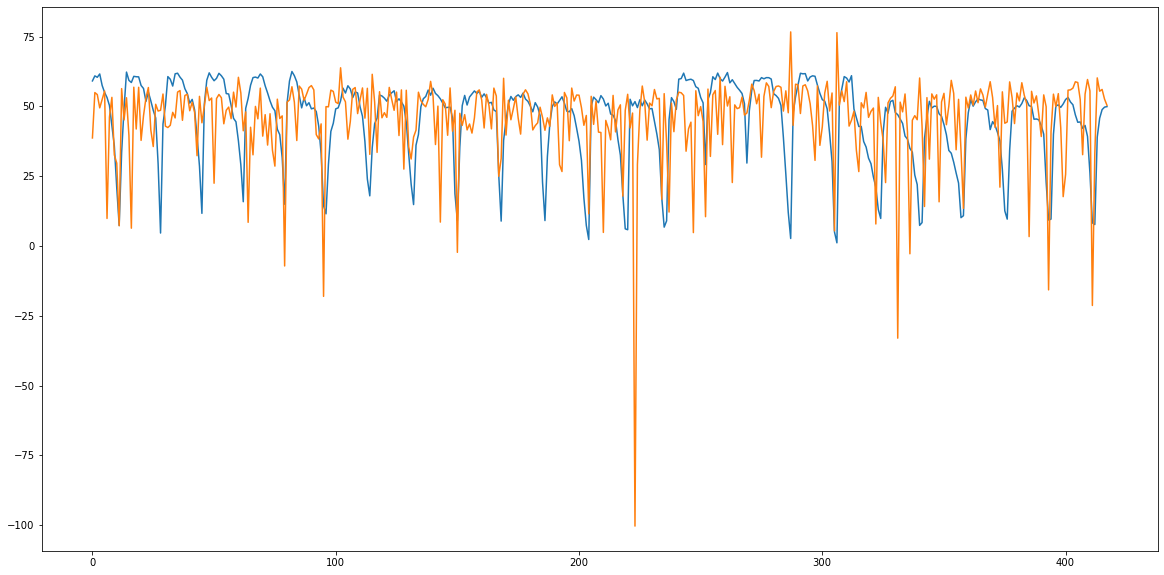

Epoch 1/10
4/4 - 4s - loss: 15994.0430
Epoch 2/10
4/4 - 4s - loss: 15986.5674
Epoch 3/10
4/4 - 4s - loss: 15979.0303
Epoch 4/10
4/4 - 4s - loss: 15971.5654
Epoch 5/10
4/4 - 4s - loss: 15964.0518
Epoch 6/10
4/4 - 4s - loss: 15956.5762
Epoch 7/10
4/4 - 4s - loss: 15949.1338
Epoch 8/10
4/4 - 4s - loss: 15941.6504
Epoch 9/10
4/4 - 5s - loss: 15934.2080
Epoch 10/10
4/4 - 4s - loss: 15926.7490


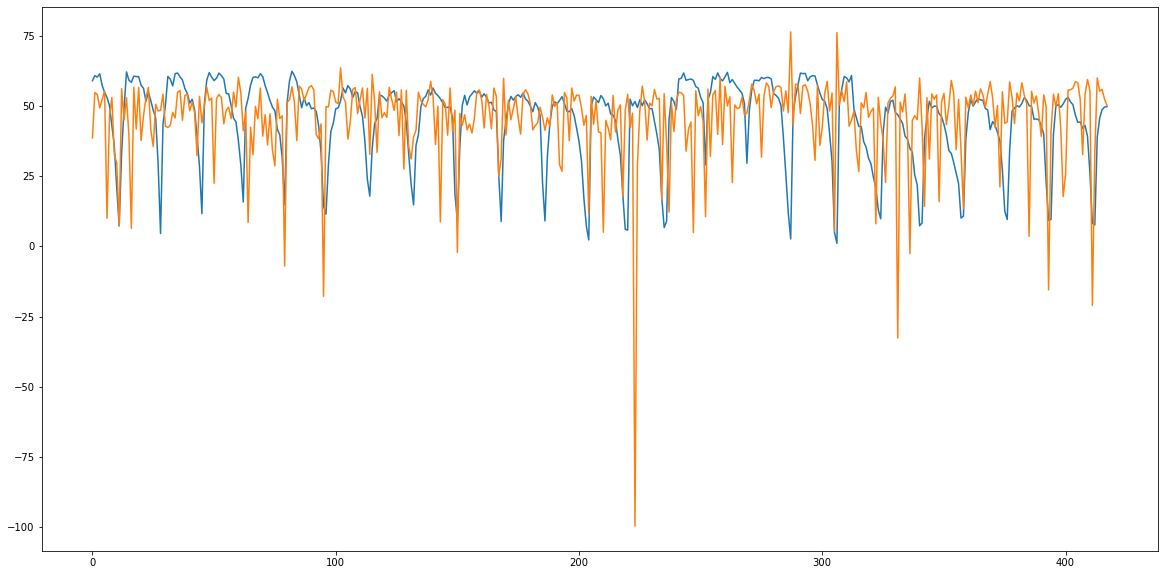

Epoch 1/10
4/4 - 4s - loss: 15919.3105
Epoch 2/10
4/4 - 4s - loss: 15911.8945
Epoch 3/10
4/4 - 4s - loss: 15904.4531
Epoch 4/10
4/4 - 4s - loss: 15897.0537
Epoch 5/10
4/4 - 4s - loss: 15889.6562
Epoch 6/10
4/4 - 4s - loss: 15882.2354
Epoch 7/10
4/4 - 4s - loss: 15874.8350
Epoch 8/10
4/4 - 4s - loss: 15867.4160
Epoch 9/10
4/4 - 4s - loss: 15860.0801
Epoch 10/10
4/4 - 4s - loss: 15852.6719


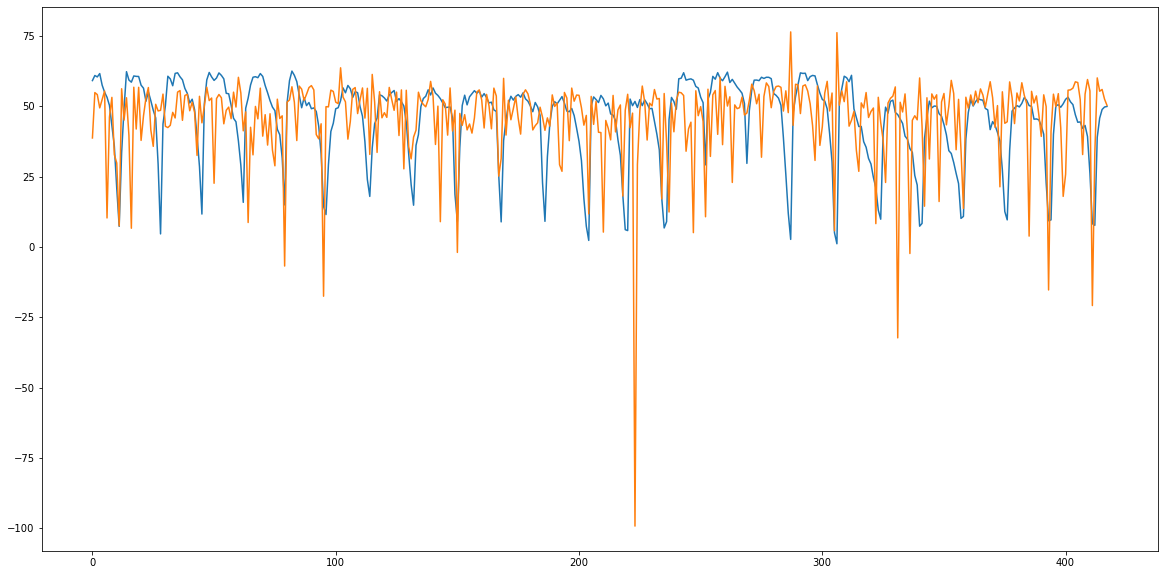

Epoch 1/10
4/4 - 4s - loss: 15845.3369
Epoch 2/10
4/4 - 4s - loss: 15837.9316
Epoch 3/10
4/4 - 4s - loss: 15830.6064
Epoch 4/10
4/4 - 4s - loss: 15823.1826
Epoch 5/10
4/4 - 4s - loss: 15815.6553
Epoch 6/10
4/4 - 4s - loss: 15808.1045
Epoch 7/10
4/4 - 4s - loss: 15800.4746
Epoch 8/10
4/4 - 4s - loss: 15792.8682
Epoch 9/10
4/4 - 4s - loss: 15785.2217
Epoch 10/10
4/4 - 4s - loss: 15777.6006


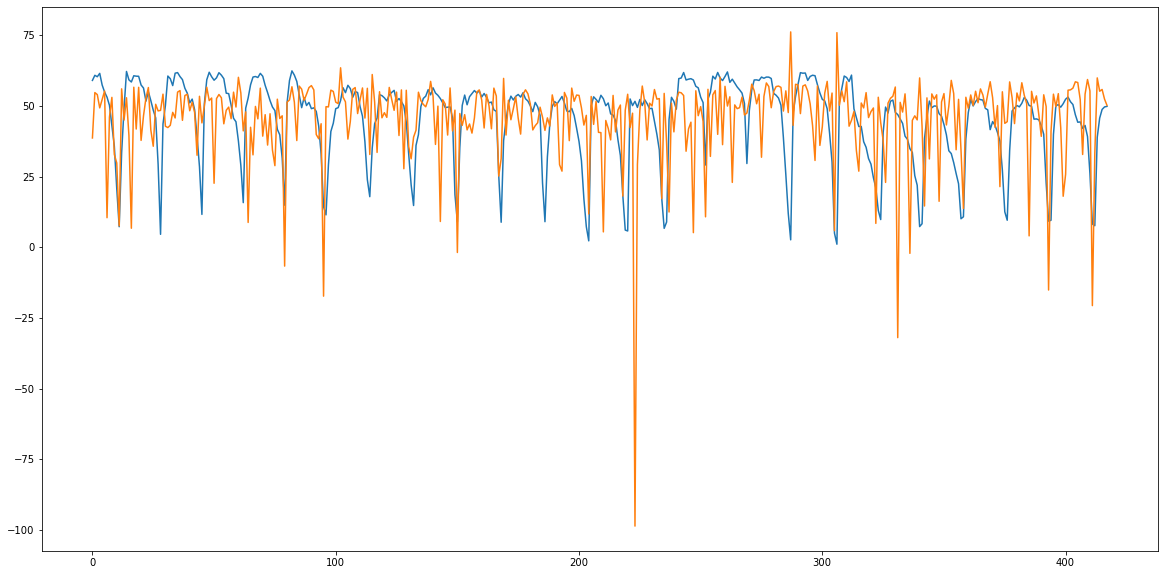

Epoch 1/10
4/4 - 4s - loss: 15769.9629
Epoch 2/10
4/4 - 4s - loss: 15762.3242
Epoch 3/10
4/4 - 4s - loss: 15754.6855
Epoch 4/10
4/4 - 4s - loss: 15747.0811
Epoch 5/10
4/4 - 4s - loss: 15739.4609
Epoch 6/10
4/4 - 4s - loss: 15731.8398
Epoch 7/10
4/4 - 4s - loss: 15724.2197
Epoch 8/10
4/4 - 4s - loss: 15716.6260
Epoch 9/10
4/4 - 4s - loss: 15709.0303
Epoch 10/10
4/4 - 6s - loss: 15701.4541


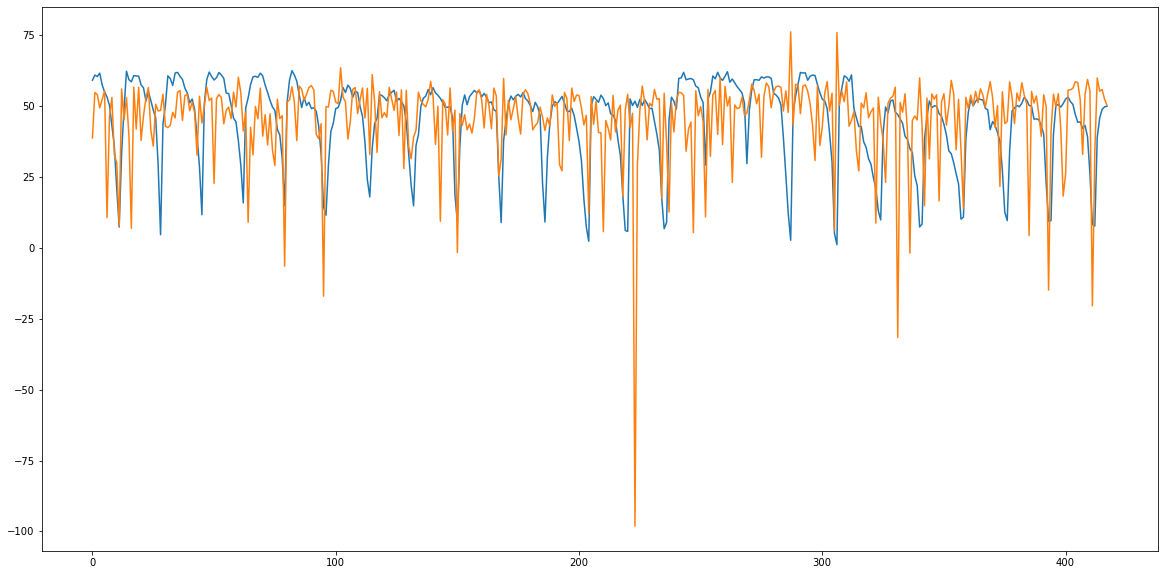

Epoch 1/10
4/4 - 6s - loss: 15693.8525
Epoch 2/10
4/4 - 5s - loss: 15686.3086
Epoch 3/10
4/4 - 4s - loss: 15678.7480
Epoch 4/10
4/4 - 5s - loss: 15671.2061
Epoch 5/10
4/4 - 6s - loss: 15663.6660
Epoch 6/10
4/4 - 4s - loss: 15656.1475
Epoch 7/10
4/4 - 4s - loss: 15648.6113
Epoch 8/10
4/4 - 4s - loss: 15641.0967
Epoch 9/10
4/4 - 6s - loss: 15633.5576
Epoch 10/10
4/4 - 7s - loss: 15626.0283


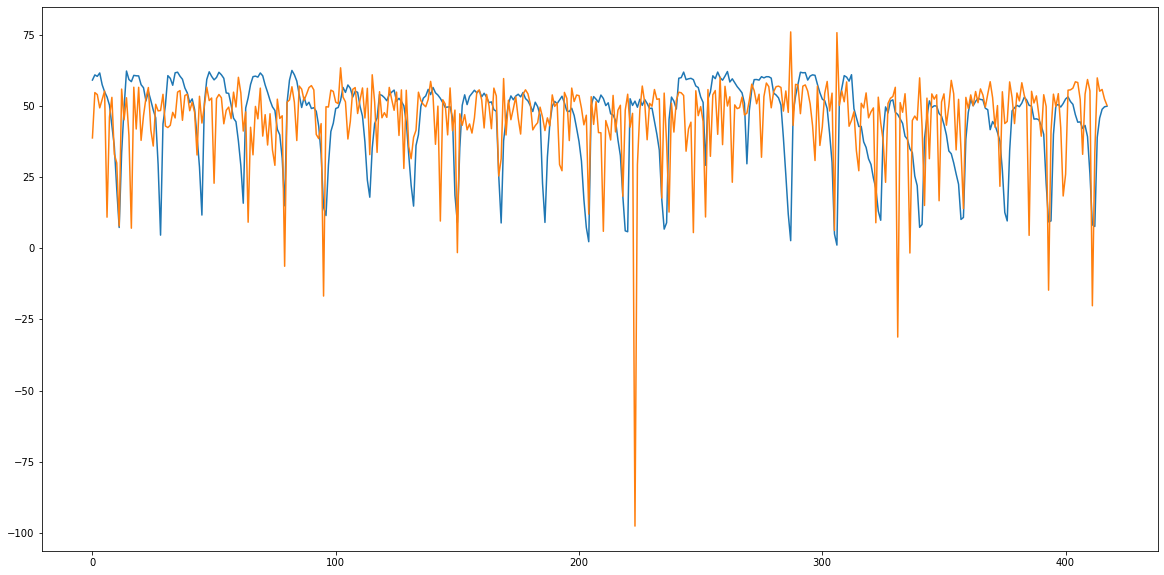

Epoch 1/10
4/4 - 5s - loss: 15618.5459
Epoch 2/10
4/4 - 6s - loss: 15611.0264
Epoch 3/10
4/4 - 5s - loss: 15603.5391
Epoch 4/10
4/4 - 4s - loss: 15596.0107
Epoch 5/10
4/4 - 4s - loss: 15588.5488
Epoch 6/10
4/4 - 4s - loss: 15581.0713
Epoch 7/10
4/4 - 4s - loss: 15573.6006
Epoch 8/10


KeyboardInterrupt: 

In [103]:
while True:
    lpm.fit(one_khz_examples, epochs=10, verbose=2)
    plot_pred(lpm, one_khz_examples)

In [ ]:
plot_pred(lpm, one_khz_examples)